## ホテリングの$T^2$法による異常検知

多変量正規分布においての異常度を算出する方法。

あるデータ$D=\{x_1, x_2, ..., x_n\}$に関して正規分布に従うと仮定する。

$$N(x|\mu, \Sigma) = \frac{|\Sigma|^{-1/2}}{(2\pi)^{M/2}}exp\left\lbrace-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right\rbrace$$

$\mu$と$\Sigma$をデータ$D$から得る方法として最尤推定が用いられる。N個のデータを独立に得たと過程すれば、$D$の対数尤度は以下で定義出来る。


$$L(\mu, \Sigma|D) = ln\prod^{N}_{n=1}N(x^{(n)}|\mu,\Sigma)=\sum^{N}_{n=1}lnN(x^{(n)}|\mu,\Sigma)$$


この対数尤度を最大化する$\mu$と$\Sigma$を求めることが最尤推定である。正規分布の式を上の式に代入する。

\begin{equation}
L(\mu, \Sigma|D) = \sum^{N}_{n=1}ln\frac{|\Sigma|^{-1/2}}{(2\pi)^{M/2}}exp\left\{-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\right\}
\end{equation}

\begin{equation}
= -\frac{MN}{2}ln(2\pi)-\frac{N}{2}ln|\Sigma|-\frac{1}{2}\sum^{N}_{n=1}(x^{(n)}-\mu)^T\Sigma^{-1}(x^{(n)}-\mu)
\end{equation}

となる。この式を最大化するような$\mu$と$\Sigma$を求めるために、$L(\mu, \Sigma|D)$を$\mu$、$\Sigma$それぞれで微分して$=0$とする。
まず、$\mu$で微分すると、

\begin{equation}
\frac{\partial L(\mu, \Sigma|D)}{\partial \mu} = \sum^{N}_{n=1}\Sigma^{-1}(x^{(n)}-\mu)
\end{equation}

となることから、最尤解$\hat{\mu}$は以下となる。以下はデータの平均値である。

\begin{equation}
\hat{\mu}=\frac{1}{N}\sum^{N}_{n=1}x^{(n)}
\end{equation}

$\Sigma$については、$-ln|\Sigma| = ln|\Sigma^{-1}|$について$\Sigma^{-1}$について微分することにより、以下の最尤解を得る。

\begin{equation}
\hat{\Sigma} = \frac{1}{N}\sum^{N}_{n=1}(x^{(n)}-\hat{\mu})(x^{(n)}-\hat{\mu})^T
\end{equation}

推定した、$\mu$と$\Sigma$を$N(x|\mu, \Sigma)$に代入し、確率密度関数を得る。観測値に関係のない定数を無視すると以下の式を得る。

\begin{equation}
a(x) = (x - \mu)^T\Sigma^{(-1)}(x - \mu)
\end{equation}

観測データ$x$がどれだけ標本平均$\mu$から離れているか表す。
$\Sigma^{(-1)}$は直感的には各軸を標準偏差で割る操作が行われており、ばらつきが大きい方向の変動は大目に見る効果がある。これをマハラノビス距離といい、この距離の大小を異常度とする。

ホテリングの$T^2$では、このマハラノビス距離による異常度$a$が従う確率分布を多項変量正規分布の過程にもとづいて明示的に導くことができる。

### ホテリングの$T^2$法

1. $x'-\hat{\mu}$は、平均0、共分散$\frac{N+1}{N}\Sigma$のM次元正規分布に従う
1. $\hat{\Sigma}$は、$x'-\hat{\mu}$と統計的に独立である
1. $T^2=\frac{N-M}{(N+1)M}a(x')$により定義されつ統計量$T^2$は自由度(M, N-M)のF分布に従う
1. N >> Mの場合は$a(x')$は近似的に自由度M、スケール因子1のカイ2乗分布に従う


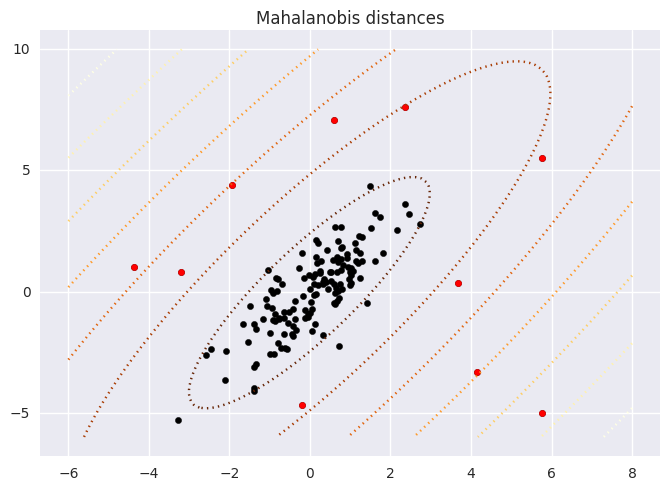

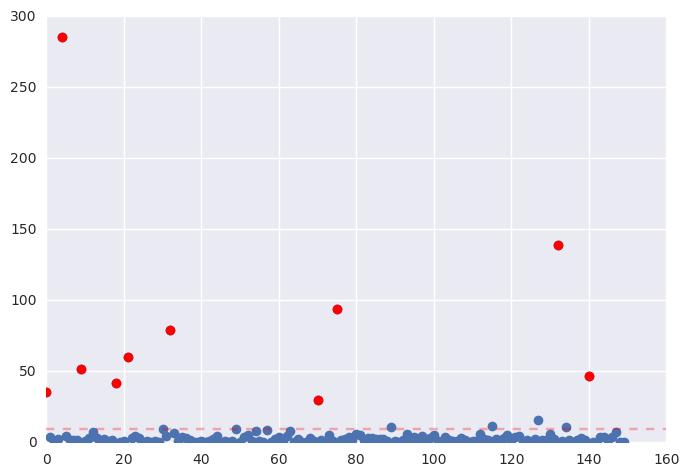

In [86]:
# マハラノビス距離の計算
# 参考: http://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2

from sklearn.covariance import MinCovDet, EmpiricalCovariance

n_baseline = 150
n_outliers = 10
n_features = 2

# 特徴量の数とカイ二乗分布から異常度の閾値を決定
th = chi2.ppf(0.99, n_features)

# 正常データの作成
baseline_cov = np.eye(n_features)
baseline_cov[0, 1] = 1.3
baseline_X = np.dot(np.random.randn(n_baseline, n_features), baseline_cov)

# 異常値を含むデータの作成
outlier_cov = np.eye(n_features)
outlier_cov[np.arange(0, n_features), np.arange(0, n_features)] = 3.
# outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.
outlier_X = np.dot(np.random.randn(n_baseline, n_features), baseline_cov)
outlier_X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outlier_cov)

# データのシャッフル
outlier_X_df = pd.DataFrame({'x1': outlier_X[:, 0], 'x2': outlier_X[:, 1],
                             'type': np.concatenate((np.zeros(n_baseline - n_outliers),
                                                     np.ones(n_outliers)))})
outlier_X_df = outlier_X_df.reindex(
    np.random.permutation(outlier_X_df.index)
).reset_index(drop=True)
outlier_X = outlier_X_df[['x1', 'x2']].values

# ベースラインデータで共分散行列を作成
emprical_cov = EmpiricalCovariance().fit(baseline_X)

# データをプロット
plt.scatter(outlier_X[:, 0], outlier_X[:, 1], color='black', label='inliers')
plt.scatter(outlier_X[:, 0][outlier_X_df.type == 1],
            outlier_X[:, 1][outlier_X_df.type == 1], color='red', label='outliers')

plt.title("Mahalanobis distances")

# マハラノビス距離における等距離線（等高線）を引く
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

contour_mahal = emprical_cov.mahalanobis(zz)
contour_mahal = contour_mahal.reshape(xx.shape)
plt.contour(xx, yy, np.sqrt(contour_mahal),
            cmap=plt.cm.YlOrBr_r, linestyles='dotted')
plt.show()

# 各データ点におけるマハラノビス距離（異常度）を算出
mahal_distance = emprical_cov.mahalanobis(outlier_X)
plt.plot(outlier_X_df.index.values, mahal_distance, 'o')
plt.axhline(y=th, c='r', alpha=.3, ls='dashed')
plt.plot(outlier_X_df[outlier_X_df.type == 1].index.values,
         mahal_distance[outlier_X_df.type == 1], 'o', color='red')
plt.show()